**Data Gathering**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import os
import re

In [2]:
twitter_archive=pd.read_csv('twitter-archive-enhanced.csv')

In [ ]:
# Please note that I do not use twitter and I'm not actually familiar with how twitter works.
# I've pasted the code below as instructed but did not compile it. It is for using the twitter API to get the information on tweet_json.txt

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [3]:
# found the documentation for reading json files https://pandas.pydata.org/docs/reference/api/pandas.read_json.html
with open('tweet-json.txt' ) as file:
    tweet_json=pd.read_json(file , lines = True)

In [4]:
#Getting image predictions file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

response

<Response [200]>

In [5]:
with open(url.split('/')[-1] , mode = 'wb') as file:
    file.write(response.content)

In [6]:
# I've opened the image-predictons.tsv with a notepad to notice that the values are separated wth tab
image_predictions=pd.read_csv('image-predictions.tsv' , sep = '\t') 

In [7]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
tweet_json.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [9]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


All the files seem ok so the gathering phase is completed

**Assessing Data**

In [10]:
df_archive=twitter_archive.copy()

In [11]:
df_json=tweet_json.copy()

In [12]:
df_image=image_predictions.copy()

In [13]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
sum(df_archive.duplicated())

0

In [15]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [16]:
sum(df_json.id.duplicated())

0

In [17]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
sum(df_image.duplicated())

0

We know here that the tweet_id can be changed to strings instead of integers. 

There is a mismatch in the number of rows in different dataframes

In [19]:
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
#I'm going to look at the texts which have the denominator other than 10. I found out that python shortens the texts above a certain character limit. This code prevents it.
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", 50)

In [21]:
df_archive.query(' rating_denominator != 10')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0,960
342,@docmisterio account started on 11/15/15,15,11
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,84
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7,24
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11,9
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150,165
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11,9
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170,204
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20,4
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [22]:
df_archive.query(' rating_numerator > 15')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,10,17
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,10,420
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",10,666
290,@markhoppus 182/10,10,182
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0,960
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",10,75
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,84
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7,24
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10,75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,10,27


We should be fixing the numerators and denominators whenever possible.

In [23]:
df_not_dog=df_image.query("p1_dog == False and p2_dog == False and p3_dog == False")['tweet_id']

In [24]:
len(df_not_dog)

324

In [25]:
for i in df_not_dog:
    print(df_archive[df_archive['tweet_id'] == i].text)

2349    This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc
Name: text, dtype: object
2338    Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX
Name: text, dtype: object
2337    Very concerned about fellow dog trapped in computer. 10/10 https://t.co/0yxApIikpk
Name: text, dtype: object
2334    This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0
Name: text, dtype: object
2330    Unique dog here. Very small. Lives in container of Frosted Flakes (?). Short legs. Must be rare 6/10 would still pet https://t.co/XMD9CwjEnM
Name: text, dtype: object
2326    This is quite the dog. Gets really excited when not in water. Not very soft tho. Bad at fetch. Can't do tricks. 2/10 https://t.co/aMCTNWO94t
Name: text, dtype: object
2310    Unfamiliar

1724    This is by far the most coordinated series of pictures I was sent. Downright impressive in every way. 12/10 for all https://t.co/etzLo3sdZE
Name: text, dtype: object
1718    This pupper is patiently waiting to scare the shit out of Santa. 10/10 https://t.co/NhXo67K6yt
Name: text, dtype: object
1716    I hope everyone enjoys this picture as much as I do. This is Toby. 12/10 https://t.co/vHnu1g9EJm
Name: text, dtype: object
1715    This is CeCe. She's patiently waiting for Santa. 10/10 https://t.co/ZJUypFFwvg
Name: text, dtype: object
1714    Merry Christmas. My gift to you is this tiny unicorn running into a wall in slow motion. 11/10 https://t.co/UKqIAnR3He
Name: text, dtype: object
1710    This is Penny. Her tennis ball slowly rolled down her cone and into the pool. 8/10 bad things happen to good puppers https://t.co/YNWU7LeFgg
Name: text, dtype: object
1708    Say hello to Moofasa. He must be a powerful dog. Fenced in for your protection. Just got his ear pierced. 6/10 https:

626    This is Bailey. She loves going down slides but is very bad at it. Still 11/10 https://t.co/ivPWhspN3E
Name: text, dtype: object
600    RT @dog_rates: I shall call him squishy and he shall be mine, and he shall be my squishy. 13/10 https://t.co/WId5lxNdPH
Name: text, dtype: object
585    Here's a doggo doin a struggle. 11/10 much determined https://t.co/gQqRBfkX4I
Name: text, dtype: object
581    RT @dog_rates: This is Sampson. He's about to get hit with a vicious draw 2. Has no idea. 11/10 poor pupper https://t.co/FYT9QBEnKG
Name: text, dtype: object
580    Here's a very sleepy pupper. Appears to be portable as h*ck. 12/10 would snug intensely https://t.co/61sX7pW5Ca
Name: text, dtype: object
572    oh h*ck 10/10 https://t.co/bC69RrW559
Name: text, dtype: object
564    This is Severus. He's here to fix your cable. Looks like he succeeded. Even offered to pupgrade your plan. 13/10 h*ckin helpful https://t.co/aX4brLLpWZ
Name: text, dtype: object
557    Meet Sonny. He's an in-home

I've noticed that there are some tweets without a dog image. However, there are also some with dogs but the image processing algorithm failed to pick up the dog. The non-dog images seem to have low rating so, I'll look into that next.

In [26]:
df_archive.query(' rating_numerator < 6')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",10,5
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,10,0
605,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,10,1
730,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,10,5
765,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,10,3
883,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,10,4
912,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl,10,4
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,10,5
1004,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,10,4
1016,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",10,0


## Data Cleaning

**Define** <br>
Merging the two dataframes into one, using outer merge.

**Code**

In [27]:
# I'll start off by doing an outer merge for the tweets. I'll drop the unnecessary rows & columns later.
#I'll rename the 'id' column in df_json so that it matches the df_archive column name 'twitter_id'
df_json.rename(columns={'id': 'tweet_id'}, inplace = True)

In [28]:
df_merged=df_archive.merge(df_json, how='outer', on='tweet_id')

**Test** <br>
Testing to make sure that the merging has succeeeded.

In [29]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 47 columns):
tweet_id                         2356 non-null int64
in_reply_to_status_id_x          78 non-null float64
in_reply_to_user_id_x            78 non-null float64
timestamp                        2356 non-null object
source_x                         2356 non-null object
text                             2356 non-null object
retweeted_status_id              181 non-null float64
retweeted_status_user_id         181 non-null float64
retweeted_status_timestamp       181 non-null object
expanded_urls                    2297 non-null object
rating_numerator                 2356 non-null int64
rating_denominator               2356 non-null int64
name                             2356 non-null object
doggo                            2356 non-null object
floofer                          2356 non-null object
pupper                           2356 non-null object
puppo                            23

**Define** <br> Missing rows in the merged df.
I see that the merged df has 2356 entries, which matches the length of df_archive. It means that df_json had two rows missing without any extra rows over df_archive.

In [30]:
df_merged[df_merged['lang'].isnull()]

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source_y,truncated,user
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @katieornah: @dog_rates learning a lot at college 12/10 for my professor thank u for the pupper slides https://t.co/nTFDr99hg0,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,"https://twitter.com/katieornah/status/771002130450743296/photo/1,https://twitter.com/katieornah/status/771002130450743296/photo/1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Code** <br>
Those extra two lines are retweets. I'll be removing all the retweets next.

In [31]:
df_merged=df_merged[df_merged['retweeted_status_id'].isnull()]

**Test** <br>
Testing that the removal worked

In [32]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 47 columns):
tweet_id                         2175 non-null int64
in_reply_to_status_id_x          78 non-null float64
in_reply_to_user_id_x            78 non-null float64
timestamp                        2175 non-null object
source_x                         2175 non-null object
text                             2175 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    2117 non-null object
rating_numerator                 2175 non-null int64
rating_denominator               2175 non-null int64
name                             2175 non-null object
doggo                            2175 non-null object
floofer                          2175 non-null object
pupper                           2175 non-null object
puppo                            2175 non

**Define** <br>
Finding and removing replies and retweets. This is done by removing rows which have a notnull value in the "quoted status" column.

In [33]:
df_merged[df_merged["quoted_status"].notnull()].text

35      I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk                                                                        
42      OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY 13/10 WOULD FORGIVE IMMEDIATE https://t.co/uF3pQ8Wubj               
72      Martha is stunning how h*ckin dare you. 13/10 https://t.co/9uABQXgjwa                                                                          
83      I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu  
88      You'll get your package when that precious man is done appreciating the pups. 13/10 for everyone https://t.co/PFp4MghzBW                       
110     Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH                                                                                              
133     He was providing for his family 13/10 how dare you https://t.co/Q8mVwWN3f4      

**Code** <br>
I've found out that there are 28 tweets which are sent as replies to others. I believe this qualifies as a retweet so I'm going to remove those as well.

In [34]:
df_merged=df_merged[df_merged['quoted_status_id'].isnull()]

**Test** <br>
Testing shows that the rows with non-null values in quoted_status (i.e. replies) are removed from the df

In [35]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2355
Data columns (total 47 columns):
tweet_id                         2147 non-null int64
in_reply_to_status_id_x          78 non-null float64
in_reply_to_user_id_x            78 non-null float64
timestamp                        2147 non-null object
source_x                         2147 non-null object
text                             2147 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    2089 non-null object
rating_numerator                 2147 non-null int64
rating_denominator               2147 non-null int64
name                             2147 non-null object
doggo                            2147 non-null object
floofer                          2147 non-null object
pupper                           2147 non-null object
puppo                            2147 non

**Define** <br>
Checking the in_reply_to_user_id_x column to find further tweets with replies to other people. They will be removed.

In [36]:
df_merged[df_merged["in_reply_to_user_id_x"].notnull()].text

30      @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution                                                            
55      @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s                                                                          
64      @RealKentMurphy 14/10 confirmed                                                                                                                                      
113     @ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs                                                                                                         
148     @Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10                               
149     Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. P

There are also 78 tweets which are replies to somoene else. I'll remove them as well.

**Code**

In [37]:
df_merged=df_merged[df_merged['in_reply_to_user_id_x'].isnull()]

**Test** <br>
Visually making sure that in_reply_to_user_id_x has no non-null values.

In [38]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 47 columns):
tweet_id                         2069 non-null int64
in_reply_to_status_id_x          0 non-null float64
in_reply_to_user_id_x            0 non-null float64
timestamp                        2069 non-null object
source_x                         2069 non-null object
text                             2069 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    2066 non-null object
rating_numerator                 2069 non-null int64
rating_denominator               2069 non-null int64
name                             2069 non-null object
doggo                            2069 non-null object
floofer                          2069 non-null object
pupper                           2069 non-null object
puppo                            2069 non-n

**Define** <br>
Change the tweet id to string

**Code**

In [39]:
df_merged['tweet_id']= df_merged['tweet_id'].astype(str)

**Test** <br>
Visual check to ensure that tweet id is stored as string.

In [40]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 47 columns):
tweet_id                         2069 non-null object
in_reply_to_status_id_x          0 non-null float64
in_reply_to_user_id_x            0 non-null float64
timestamp                        2069 non-null object
source_x                         2069 non-null object
text                             2069 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    2066 non-null object
rating_numerator                 2069 non-null int64
rating_denominator               2069 non-null int64
name                             2069 non-null object
doggo                            2069 non-null object
floofer                          2069 non-null object
pupper                           2069 non-null object
puppo                            2069 non-

**Define** <br>
Change timestamp to datetime.

**Code**

In [41]:
df_merged['timestamp']= pd.to_datetime(df_merged['timestamp'])

**Test** <br>
Visual check to ensure that timestamp is stored as datetime

In [42]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 47 columns):
tweet_id                         2069 non-null object
in_reply_to_status_id_x          0 non-null float64
in_reply_to_user_id_x            0 non-null float64
timestamp                        2069 non-null datetime64[ns]
source_x                         2069 non-null object
text                             2069 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    2066 non-null object
rating_numerator                 2069 non-null int64
rating_denominator               2069 non-null int64
name                             2069 non-null object
doggo                            2069 non-null object
floofer                          2069 non-null object
pupper                           2069 non-null object
puppo                            2

**Define**
Ratings are to be modified.

In [43]:
df_merged.query(' rating_denominator != 10')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,84
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7,24
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150,165
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11,9
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170,204
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20,4
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90,99
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50,45


**Code** <br>
Drop row 516 because it does not have a rating.

In [44]:
df_merged.drop(516, inplace=True)

**Test** <br>
Confirm that the drop works

In [45]:
df_merged.query(' rating_denominator != 10').text

433     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                               
902     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                    
1068    After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ      
1120    Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                         
1165    Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                                                                  
1202    This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq                             
1228    Happy Saturday here's 9 puppers on a bench. 99/90 good work ev

**Code** <br>
Update rating numerators and denominators where denominator is not 10 originally

In [46]:
df_merged.loc[433 , 'rating_numerator'] =12
df_merged.loc[902 , 'rating_numerator'] =11
df_merged.loc[1068 , 'rating_numerator'] =14
df_merged.loc[1120 , 'rating_numerator'] =12
df_merged.loc[1165 , 'rating_numerator'] =13
df_merged.loc[1202 , 'rating_numerator'] =11
df_merged.loc[1228 , 'rating_numerator'] =11
df_merged.loc[1254 , 'rating_numerator'] =10
df_merged.loc[1274 , 'rating_numerator'] =9
df_merged.loc[1351 , 'rating_numerator'] =12
df_merged.loc[1433 , 'rating_numerator'] =11
df_merged.loc[1635 , 'rating_numerator'] =11
df_merged.loc[1662 , 'rating_numerator'] =10
df_merged.loc[1779 , 'rating_numerator'] =12
df_merged.loc[1843 , 'rating_numerator'] =11
df_merged.loc[2335 , 'rating_numerator'] =9

In [47]:
df_merged.loc[433 , 'rating_denominator'] =10
df_merged.loc[902 , 'rating_denominator'] =10
df_merged.loc[1068 , 'rating_denominator'] =10
df_merged.loc[1120 , 'rating_denominator'] =10
df_merged.loc[1165 , 'rating_denominator'] =10
df_merged.loc[1202 , 'rating_denominator'] =10
df_merged.loc[1228 , 'rating_denominator'] =10
df_merged.loc[1254 , 'rating_denominator'] =10
df_merged.loc[1274 , 'rating_denominator'] =10
df_merged.loc[1351 , 'rating_denominator'] =10
df_merged.loc[1433 , 'rating_denominator'] =10
df_merged.loc[1635 , 'rating_denominator'] =10
df_merged.loc[1662 , 'rating_denominator'] =10
df_merged.loc[1779 , 'rating_denominator'] =10
df_merged.loc[1843 , 'rating_denominator'] =10
df_merged.loc[2335 , 'rating_denominator'] =10

**Test** <br>
Confirm that all the denominators are 10

In [48]:
df_merged.query(' rating_denominator != 10').text

Series([], Name: text, dtype: object)

**Define** <br>
We've fixed all the denominator issues, now we'll proceed with the numerator.

In [49]:
df_merged.query(' rating_numerator > 15')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10,75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,10,27
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,10,1776
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,10,26
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,10,420


**Code** <br>
Drop the dogg

In [50]:
df_merged.drop(2074, inplace=True)

**Code** <br>
Fix the numerators, rounding them to integers whenever necessary. I've assigned the median value of 11 to Atticus instead of 1776

In [51]:
df_merged.loc[695 , 'rating_numerator'] =10
df_merged.loc[763 , 'rating_numerator'] =11
df_merged.loc[979 , 'rating_numerator'] =11
df_merged.loc[1712 , 'rating_numerator'] =11

**Test** <br>
Confirm that the outliers in the numerators are fixed.

In [52]:
df_merged.rating_numerator.describe()

count    2067.000000
mean     10.583454  
std      2.145297   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      14.000000  
Name: rating_numerator, dtype: float64

In [53]:
len(df_merged.query(' rating_numerator < 6')[['text', 'rating_denominator', 'rating_numerator']])

82

In [54]:
df_merged.query(' rating_numerator < 6')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",10,5
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,10,0
730,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,10,5
765,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,10,3
883,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,10,4
912,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl,10,4
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,10,5
1004,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,10,4
1189,This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl,10,3
1219,This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet https://t.co/3oeFfHjv0Z,10,4


I can see that the majority of the items above are pictures of things other than dogs. I'll now merge the image file and drop the rows without image info. Hopefully, some of the low numerator rows will be gone. I can then manually look at all the ones remaining.

**Define** <br>
Convert the tweet_id on df_image to string, then do an inner merge with the df_image.

**Code**

In [55]:
df_image['tweet_id']= df_image['tweet_id'].astype(str)

In [56]:
df_merged_final=df_merged.merge(df_image, how='inner', on='tweet_id')

**Test**

In [57]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1968
Data columns (total 58 columns):
tweet_id                         1969 non-null object
in_reply_to_status_id_x          0 non-null float64
in_reply_to_user_id_x            0 non-null float64
timestamp                        1969 non-null datetime64[ns]
source_x                         1969 non-null object
text                             1969 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1969 non-null object
rating_numerator                 1969 non-null int64
rating_denominator               1969 non-null int64
name                             1969 non-null object
doggo                            1969 non-null object
floofer                          1969 non-null object
pupper                           1969 non-null object
puppo                            1

In [58]:
sum(df_merged_final.tweet_id.duplicated())

0

In [59]:
len(df_merged_final.query(' rating_numerator < 6')[['text', 'rating_denominator', 'rating_numerator']])

81

I do not want to go through all 81 of the tweets manually. I'll remove the rows if the numerator is below 6 and the image predictor does not find any dogs.

**Define** <br>
Remove tweets which are not dogs. I'll remove the rows if the numerator is below 6 (dog tweets are rated higher) or the image predictor does not find any dogs

**Code**

In [60]:
df_merged_final=df_merged_final.query(" rating_numerator > 5 or p1_dog == True or p2_dog==True or p3_dog==True")

**Test** <br>
Test to check the remaining rows with low ratings.

In [61]:
len(df_merged_final.query(' rating_numerator < 6')[['text', 'rating_denominator', 'rating_numerator']])

28

I think I can at least have a look at these 28 rows to see what can be done

In [62]:
df_merged_final.query(' rating_numerator < 6').text

39      This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948        
232     When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag                               
525     Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC                      
549     This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M    
699     Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8        
743     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R      
907     This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. 

**Define** <br>
Continue removing tweets without dogs

**Code** <br>

In [63]:
#drop tweets without dogs
df_merged_final.drop(549, inplace=True)
df_merged_final.drop(907, inplace=True)
df_merged_final.drop(1003, inplace=True)
df_merged_final.drop(1296, inplace=True)
df_merged_final.drop(1348, inplace=True)
df_merged_final.drop(1562, inplace=True)
df_merged_final.drop(1602, inplace=True)
df_merged_final.drop(1691, inplace=True)
df_merged_final.drop(1799, inplace=True)
df_merged_final.drop(1902, inplace=True)
df_merged_final.drop(1929, inplace=True)

**Test** <br>
Check the remaining rows with low ratings

In [64]:
df_merged_final.query(' rating_numerator < 6')[['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
39,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",10,5
232,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,10,0
525,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,10,5
699,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,10,5
743,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,10,4
957,What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz,10,3
1178,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,10,5
1406,This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz,10,2
1435,This is Juckson. He's totally on his way to a nascar race. 5/10 for Juckson https://t.co/IoLRvF0Kak,10,5
1456,This is Bubbles. He kinda resembles a fish. Always makes eye contact with u no matter what. Sneaky tongue slip. 5/10 https://t.co/Nrhvc5tLFT,10,5


**Define** <br>
Update incorrect numerator values manually.

**Code**

In [65]:
df_merged_final.loc[39 , 'rating_numerator'] =14
df_merged_final.loc[232 , 'rating_numerator'] =11
df_merged_final.loc[1178 , 'rating_numerator'] =10
df_merged_final.loc[1528 , 'rating_numerator'] =8
df_merged_final.loc[1862 , 'rating_numerator'] =12

**Define** <br>
drop unnecessary columns after the merges and retweet row removals

**Code**

In [66]:
df_merged_final.dropna(axis=1,inplace = True)

**Test**

In [67]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905 entries, 0 to 1968
Data columns (total 40 columns):
tweet_id                         1905 non-null object
timestamp                        1905 non-null datetime64[ns]
source_x                         1905 non-null object
text                             1905 non-null object
expanded_urls                    1905 non-null object
rating_numerator                 1905 non-null int64
rating_denominator               1905 non-null int64
name                             1905 non-null object
doggo                            1905 non-null object
floofer                          1905 non-null object
pupper                           1905 non-null object
puppo                            1905 non-null object
created_at                       1905 non-null datetime64[ns]
display_text_range               1905 non-null object
entities                         1905 non-null object
extended_entities                1905 non-null object
favorite_count 

In [68]:
df_merged_final.describe()

,rating_numerator,rating_denominator,favorite_count,id_str,possibly_sensitive,possibly_sensitive_appealable,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,1905.000000,1905.0,1905.000000,1.905000e+03,1905.0,1905.0,1905.000000,1905.000000,1905.000000,1.905000e+03,1.905000e+03
mean,10.794751,10.0,9160.129659,7.378684e+17,0.0,0.0,2836.297638,1.208924,0.597710,1.350242e-01,6.006438e-02
std,1.738218,0.0,12415.390429,6.777316e+16,0.0,0.0,4764.325105,0.567339,0.271061,1.014926e-01,5.105211e-02
min,2.000000,10.0,81.000000,6.660209e+17,0.0,0.0,16.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.0,2071.000000,6.767764e+17,0.0,0.0,635.000000,1.000000,0.367945,5.351500e-02,1.594270e-02
50%,11.000000,10.0,4229.000000,7.113067e+17,0.0,0.0,1397.000000,1.000000,0.596455,1.181810e-01,4.917630e-02
75%,12.000000,10.0,11659.000000,7.909461e+17,0.0,0.0,3300.000000,1.000000,0.848704,1.959500e-01,9.160200e-02
max,14.000000,10.0,132810.000000,8.924206e+17,0.0,0.0,79515.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


**Define** <br>
Fix the incorrect dog names such as "a" "an" or "the".

In [69]:
df_merged_final.query("name == 'the'").text

1195    Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx                               
1261    This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn    
1436    This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb                                                
1453    This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF                                                      
1659    This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU
1958    This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK                                     
1959    Here is the Rand Paul of retrievers folks! He's probably good at poker. Ca

In [70]:
df_merged_final.query("name == 'a'").text

49      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
467     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
577     Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn               
741     This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
743     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
751     This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2                     
776     This is 

I can see the pattern here, where the regex looks for the expression "this is" or "here is" and picks up the word after it as the name. I'll change all of them to none. <br>
I've also noticed that I can look for the the expression "named" or "name is" and then use that to pick up the name.

**Code** <br>
Replace the incorrect names with None. Rows with no names will be handled later in the code.

In [71]:
df_merged_final.name.replace('the', 'None' , inplace=True)
df_merged_final.name.replace('a', 'None' , inplace=True)
df_merged_final.name.replace('an', 'None' , inplace=True)

**Test** <br>
Ensure that there are no incorrect names such as "the" "a" or "an"

In [72]:
df_merged_final.name.value_counts()

None       552
Charlie    11 
Lucy       10 
Cooper     10 
Oliver     10 
Tucker     9  
Penny      9  
Winston    8  
Sadie      8  
Lola       7  
Toby       7  
Daisy      7  
Bo         6  
Koda       6  
Jax        6  
Bella      6  
Stanley    6  
Bailey     5  
Rusty      5  
Louis      5  
Leo        5  
Chester    5  
Milo       5  
Buddy      5  
Oscar      5  
          ..  
Farfle     1  
Hanz       1  
Kellogg    1  
Sandra     1  
Brandy     1  
Banditt    1  
Jackie     1  
Stark      1  
Chloe      1  
Marlee     1  
Ginger     1  
Fillup     1  
Link       1  
Tonks      1  
Harlso     1  
Darrel     1  
Anakin     1  
Robin      1  
Shelby     1  
Mya        1  
Laika      1  
Akumi      1  
Chaz       1  
Mack       1  
Emma       1  
Name: name, Length: 921, dtype: int64

**Define** <br>
Checks whether the name is 'None' and my regex can find something after the phrase 'named'. I'll repeat it for the phrase 'name is

**Code** <br>
Changing the name if it is preceeded by the word "named".

In [73]:
# The code below checks whether the name is 'None' and my regex can find something after the phrase 'named'. I'll repeat it for the phrase 'name is' next
for i in df_merged_final.index:
    if (re.findall(r"named\s(\w+)",df_merged_final.text[i]) != []) and (df_merged_final.name[i] == "None"):
        #I had to check for whether the regex would find something beforehand. The code fails for some reason when regex returns []
        df_merged_final.loc[i, 'name']=re.findall(r"named\s(\w+)",df_merged_final.text[i])
        print(df_merged_final.text[i])
        print(df_merged_final.name[i])

This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI
Wylie
This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3
Kip
This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7
Jacob
This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr
Rufus
This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo
Spork
This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj
Cherokee
This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.c

**Code** <br>
Changing the name if it is preceeded by the phrase "name is".

In [74]:
for i in df_merged_final.index:
    if (re.findall(r"name is\s(\w+)",df_merged_final.text[i]) != []) and (df_merged_final.name[i] == "None"):
        #I had to check for whether the regex would find something beforehand. The code fails for some reason when regex returns []
        df_merged_final.loc[i, 'name']=re.findall(r"name is\s(\w+)",df_merged_final.text[i])
        print(df_merged_final.text[i])
        print(df_merged_final.name[i])

Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0
Zoey
We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT
Thea
This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP
Sabertooth
Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm
Big
This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW
Daryl


**Test** <br>
Final check for the dog names.

In [75]:
df_merged_final.name.value_counts()

None       524
Charlie    11 
Lucy       10 
Cooper     10 
Oliver     10 
Penny      9  
Tucker     9  
Winston    8  
Sadie      8  
Toby       7  
Lola       7  
Daisy      7  
Bella      6  
Bo         6  
Jax        6  
Stanley    6  
Koda       6  
Bailey     5  
Buddy      5  
Milo       5  
Chester    5  
Leo        5  
Scout      5  
Oscar      5  
Louis      5  
          ..  
Kellogg    1  
Dixie      1  
Harlso     1  
Olaf       1  
Brandy     1  
Banditt    1  
Jackie     1  
Stark      1  
Chloe      1  
Marlee     1  
Ginger     1  
Fillup     1  
Link       1  
Sandra     1  
Tonks      1  
Darrel     1  
Anakin     1  
Robin      1  
Shelby     1  
Mya        1  
Laika      1  
Akumi      1  
Chaz       1  
Mack       1  
Emma       1  
Name: name, Length: 944, dtype: int64

**Define** <br>
Merge all of the dog types into a single column.

**Code** <br>
Replace the phrase "none" with "" so that when I add up the four columns I do not get the phrase "none" in my string

In [76]:
df_merged_final.doggo.replace('None', '' , inplace=True)
df_merged_final.floofer.replace('None', '', inplace=True)
df_merged_final.pupper.replace('None', '', inplace=True)
df_merged_final.puppo.replace('None', '', inplace=True)

**Code** <br>
Add the four columns together and put NaN for rows without any values.

In [77]:
df_merged_final["dog_type"]=df_merged_final.doggo +df_merged_final.floofer+df_merged_final.pupper+df_merged_final.puppo
df_merged_final.dog_type.replace('', np.nan, inplace = True)
df_merged_final.dog_type.value_counts()

pupper          199
doggo           63 
puppo           22 
doggopupper     8  
floofer         7  
doggofloofer    1  
doggopuppo      1  
Name: dog_type, dtype: int64

**Code** <br>
Remove tweets which have more than one category.

In [78]:
df_merged_final[df_merged_final['dog_type'] == 'doggopupper'].text

337    This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
393    Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho                    
420    This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj                    
505    This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
647    Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll                    
699    Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7q

In [79]:
df_merged_final.loc[337 , 'dog_type'] ='pupper'
df_merged_final.loc[393 , 'dog_type'] ='doggo'
df_merged_final.loc[420 , 'dog_type'] ='pupper'
df_merged_final.loc[505 , 'dog_type'] ='doggo'
df_merged_final.loc[647 , 'dog_type'] ='doggo'
df_merged_final.loc[699 , 'dog_type'] ='doggo'
df_merged_final.loc[788 , 'dog_type'] ='doggo'
df_merged_final.loc[834 , 'dog_type'] ='doggo'

In [80]:
df_merged_final[df_merged_final['dog_type'] == 'doggofloofer'].text

152    At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
Name: text, dtype: object

In [81]:
#change the dog type to doggo for row 152
df_merged_final.loc[152 , 'dog_type'] ='doggo'

In [82]:
df_merged_final[df_merged_final['dog_type'] == 'doggopuppo'].text

146    Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
Name: text, dtype: object

In [83]:
df_merged_final.loc[146 , 'dog_type'] ='puppo'

**Test** <br>
Convert the dog_type to category and check the final result.

In [84]:
df_merged_final.dog_type=df_merged_final.dog_type.astype('category')
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905 entries, 0 to 1968
Data columns (total 41 columns):
tweet_id                         1905 non-null object
timestamp                        1905 non-null datetime64[ns]
source_x                         1905 non-null object
text                             1905 non-null object
expanded_urls                    1905 non-null object
rating_numerator                 1905 non-null int64
rating_denominator               1905 non-null int64
name                             1905 non-null object
doggo                            1905 non-null object
floofer                          1905 non-null object
pupper                           1905 non-null object
puppo                            1905 non-null object
created_at                       1905 non-null datetime64[ns]
display_text_range               1905 non-null object
entities                         1905 non-null object
extended_entities                1905 non-null object
favorite_count 

**Define** <br>
Remove the unnecessary dog category columns

**Code**

In [85]:
df_merged_final.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)

## Analysis and Visualization

In [104]:
#We can see that our cleaned sample size is 1905
len(df_merged_final)

1905

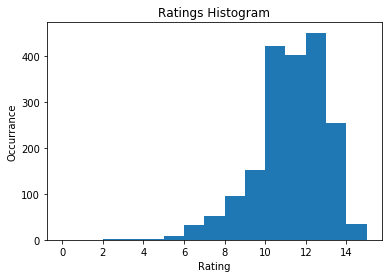

In [114]:
bins=np.arange(0, df_merged_final["rating_numerator"].max() +2, 1)
plt.hist(df_merged_final.rating_numerator, bins=bins);
plt.title("Ratings Histogram");
plt.xlabel("Rating");
plt.ylabel("Occurrance");

In [103]:
df_merged_final.rating_numerator.describe()

count    1905.000000
mean     10.794751  
std      1.738218   
min      2.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      14.000000  
Name: rating_numerator, dtype: float64

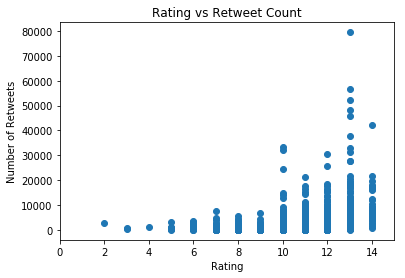

In [88]:
plt.scatter(df_merged_final.rating_numerator, df_merged_final.retweet_count);
plt.title("Rating vs Retweet Count");
plt.xlabel("Rating");
plt.ylabel("Number of Retweets");
plt.xlim([0,15]);

I was not expecting a correlation between the rating and the tweet count to be honest. I thought that the ratings were somewhat arbitrary. I'll average the retweet count for each rating to get a clearer picture.

In [110]:
retweet_average=[]
for i in range(15):
    if (len(df_merged_final.retweet_count[df_merged_final["rating_numerator"] == i])== 0):
        retweet_average.append(0)
    else:
        retweet_average.append( sum(df_merged_final.retweet_count[df_merged_final["rating_numerator"] == i]) / (len(df_merged_final.retweet_count[df_merged_final["rating_numerator"] == i])))    

In [111]:
retweet_average

[0,
 0,
 2880.0,
 587.5,
 1316.0,
 900.0,
 1043.625,
 1064.1960784313726,
 901.0833333333334,
 803.0066225165563,
 1558.1282660332542,
 2204.634328358209,
 3122.1152993348114,
 7092.062992125984,
 9813.0]

In [112]:
retweet_len=[]
for i in range(15):
        retweet_len.append( (len(df_merged_final.retweet_count[df_merged_final["rating_numerator"] == i])))    

In [113]:
#I want to make sure that the average values I'm checking are not affected by low sample sizes for some of the bins.
retweet_len

[0, 0, 1, 2, 1, 8, 32, 51, 96, 151, 421, 402, 451, 254, 35]

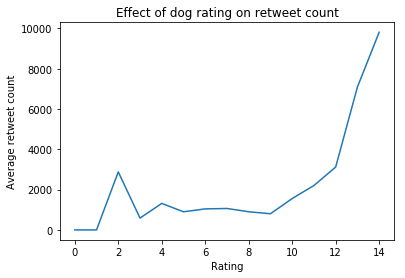

In [102]:
plt.plot(retweet_average);
plt.title("Effect of dog rating on retweet count");
plt.xlabel("Rating");
plt.ylabel("Average retweet count");

## Storing the Data

In [116]:
df_merged_final.to_csv("twitter_archive_master.csv")